In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Define the affine coupling layer
class AffineCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_dim=256, mask_type='alternate', split_type='top'):
        super(AffineCouplingLayer, self).__init__()
        self.dim = dim
        if mask_type == 'alternate':
            mask = torch.zeros(dim)
            mask[::2] = 1
        elif mask_type == 'split':
            mask = torch.zeros(dim)
            if split_type == 'top':
                mask[:dim//2] = 1
            elif split_type == 'bottom':
                mask[dim//2:] = 1
        self.register_buffer('mask', mask.reshape(1, -1))
                
        # Neural network to predict scale and translation factors
        # Input: masked dimensions
        # Output: scale and translation for non-masked dimensions
        self.nn = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim * 2)  # 2*dim for scale and translation
        )
    
    def forward(self, x):
        """Forward transformation: x -> z"""
        # x shape: [batch_size, dim]
        batch_size = x.shape[0]
        
        # Apply mask to isolate inputs to the NN
        x_masked = x * self.mask
        
        # Get scale and translation from NN
        nn_out = self.nn(x_masked)
        s, t = torch.chunk(nn_out, 2, dim=1)
        
        # Apply tanh for stability and to bound scale
        s = torch.tanh(s) * 0.5  # Scale factor bounded to [-0.5, 0.5]
        
        # Apply scale and translation only to unmasked dimensions
        z = x.clone()
        z_unmasked = x * (1 - self.mask)
        z = x_masked + (z_unmasked * torch.exp(s) + t) * (1 - self.mask)
        
        # Log determinant of Jacobian
        log_det = torch.sum(s * (1 - self.mask), dim=1)
        
        return z, log_det
    
    def inverse(self, z):
        """Inverse transformation: z -> x"""
        # z shape: [batch_size, dim]
        batch_size = z.shape[0]
        
        # Apply mask to isolate inputs to the NN
        z_masked = z * self.mask
        
        # Get scale and translation from NN
        nn_out = self.nn(z_masked)
        s, t = torch.chunk(nn_out, 2, dim=1)
        
        # Apply tanh for stability and to bound scale
        s = torch.tanh(s) * 0.5  # Scale factor bounded to [-0.5, 0.5]
        
        # Apply inverse scale and translation to unmasked dimensions
        x = z.clone()
        z_unmasked = z * (1 - self.mask)
        x = z_masked + ((z_unmasked - t) * torch.exp(-s)) * (1 - self.mask)
        
        # Log determinant of inverse Jacobian (negative of forward)
        log_det = -torch.sum(s * (1 - self.mask), dim=1)
        
        return x, log_det

In [4]:
# Define the normalizing flow model
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_flows=8, hidden_dim=256):
        super(NormalizingFlow, self).__init__()
        self.dim = dim
        
        # Create sequence of affine coupling layers with alternating masks
        self.flows = nn.ModuleList([
            AffineCouplingLayer(dim, hidden_dim, 'alternate' if i % 2 == 0 else 'split',
                        split_type='top' if i == 1 else 'bottom' if i == 3 else 'alternate'
            ) for i in range(n_flows)
        ])
        
    def forward(self, x):
        """Transform from data space to latent space: x -> z"""
        batch_size = x.shape[0]
        log_det_total = torch.zeros(batch_size, device=x.device)
        
        z = x
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_total += log_det
            
        return z, log_det_total
    
    def inverse(self, z):
        """Transform from latent space to data space: z -> x"""
        batch_size = z.shape[0]
        log_det_total = torch.zeros(batch_size, device=z.device)
        
        x = z
        # Apply flows in reverse order
        for flow in reversed(self.flows):
            x, log_det = flow.inverse(x)
            log_det_total += log_det
            
        return x, log_det_total
    
    def log_prob(self, x):
        """Compute log probability of x under the flow-based model"""
        z, log_det = self.forward(x)
        
        # Standard Gaussian prior
        log_prob_z = -0.5 * torch.sum(z**2 + np.log(2*np.pi), dim=1)
        
        # Change of variables formula
        log_prob_x = log_prob_z + log_det
        
        return log_prob_x
    
    def sample(self, n_samples):
        """Generate samples from the flow-based model"""
        # Sample from standard Gaussian prior
        z = torch.randn(n_samples, self.dim, device=next(self.parameters()).device)
        
        # Transform to data space
        x, _ = self.inverse(z)
        
        return x



In [ ]:
# Training parameters
n_epochs = 200
batch_size = 128
lr = 1e-3
device = torch.device('cuda:3')

In [6]:
model = NormalizingFlow(dim=784, n_flows=4, hidden_dim=256)
model = model.to(device)

In [7]:
optimizer = optim.Adam(model.parameters(), lr=lr)


/home/admyyh/miniconda3/envs/ultralytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from torchvision import datasets, transforms

# Transform the images to tensors and flatten them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 images
])

# Load the dataset
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a data loader to efficiently load the entire dataset
train_loader = torch.utils.data.DataLoader(
    mnist_dataset, batch_size=batch_size, shuffle=True
)

Epoch 1/20, Loss: 52.2274


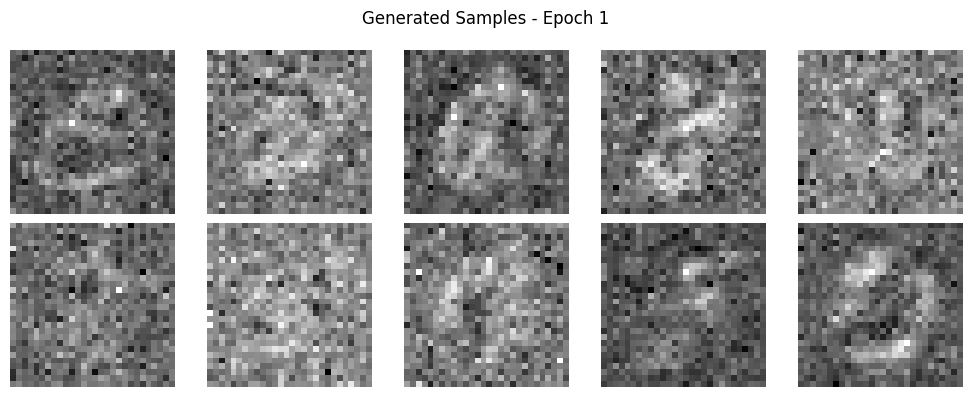

Epoch 2/20, Loss: -8.1655
Epoch 3/20, Loss: -17.6047
Epoch 4/20, Loss: -22.5625
Epoch 5/20, Loss: -25.6859


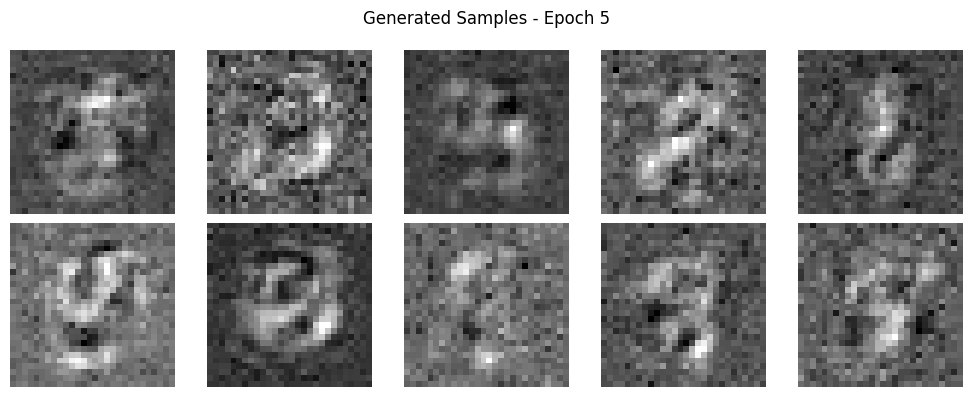

Epoch 6/20, Loss: -28.0181
Epoch 7/20, Loss: -29.7215
Epoch 8/20, Loss: -30.2822
Epoch 9/20, Loss: -32.4334
Epoch 10/20, Loss: -33.3902


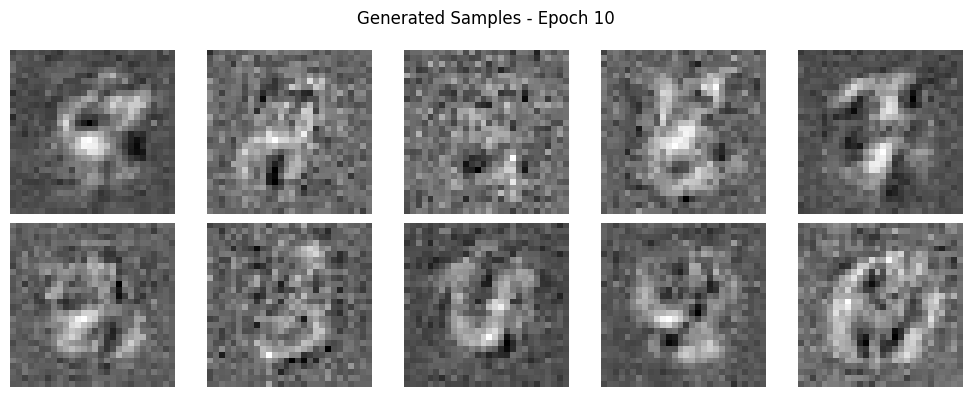

Epoch 11/20, Loss: -34.3117
Epoch 12/20, Loss: -33.5381
Epoch 13/20, Loss: -35.7596
Epoch 14/20, Loss: -35.2120
Epoch 15/20, Loss: -35.1477


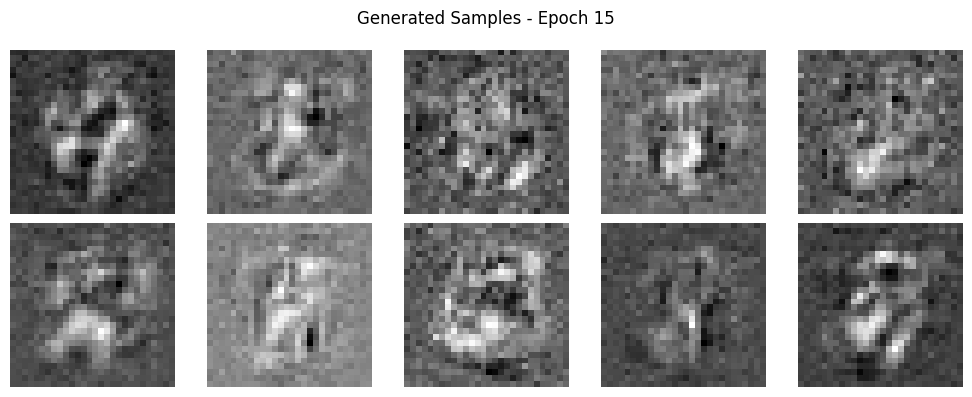

Epoch 16/20, Loss: -37.3874
Epoch 17/20, Loss: -37.8515
Epoch 18/20, Loss: -35.1220
Epoch 19/20, Loss: -38.1497
Epoch 20/20, Loss: -39.0053


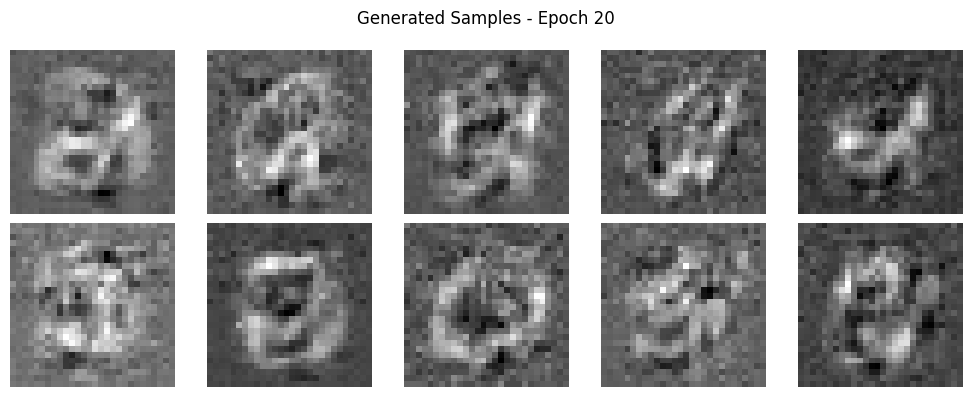

In [9]:
losses = []
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0.0
    n_batches = 0
    
    # Batch training using DataLoader
    for batch, _ in train_loader:  # _ ignores the labels
        batch = batch.to(device)
        # Compute log probability
        log_prob = model.log_prob(batch)
        
        # Negative log-likelihood loss
        loss = -torch.mean(log_prob)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    
    # Generate and visualize images every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        plt.figure(figsize=(10, 4))
        
        # Generate samples
        with torch.no_grad():
            samples = model.sample(10)
        
        # Plot the samples
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(samples[i].reshape(28, 28).cpu().numpy(), cmap='gray')
            plt.axis('off')
        
        plt.suptitle(f'Generated Samples - Epoch {epoch+1}')
        plt.tight_layout()
        plt.show()
        